## Showing min variance and efficient portfolio

In [78]:
import datetime as dt
import numpy as np
import pandas as pd
from numpy import dot
from numpy import divide
from numpy.linalg import multi_dot as mdot
from numpy.linalg import inv
import matplotlib.pyplot as plt
import quadprog
import yfinance
import os

### Downloading historical data

In [81]:
spx = pd.read_csv('efficient_frontier/spx.csv').stack().tolist()

In [3]:
raw_data = yfinance.download(spx, start="2013-1-1", back_adjust=True, auto_adjust=True)
closing_prices = raw_data['Close']
r_f = 0.01
returns = closing_prices.pct_change().iloc[1:].ffill()-((1+r_f)**(1/250)-1)

[*********************100%***********************]  504 of 504 completed

10 Failed downloads:
- TIF: No data found, symbol may be delisted
- NBL: No data found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted
- CTL: No data found, symbol may be delisted
- MYL: No data found, symbol may be delisted
- BRK.B: No data found, symbol may be delisted
- FLIR: No data found, symbol may be delisted
- CXO: No data found, symbol may be delisted
- ETFC: No data found, symbol may be delisted
- VAR: No data found, symbol may be delisted


### Calculating annual expected return $\mu$ and volatility $\sigma$

In [19]:
returns = returns.ffill()
returns = returns.dropna(axis = 1, how = 'any')
returns = returns*100
mu = returns.mean()*250
std = returns.std()*(250**0.5)

### Calculating minimum variance portfolio

In [20]:
Sigma = returns.cov().values
Sigma_inv = inv(Sigma)
one = np.ones((len(Sigma_inv)))

In [21]:
v_t_mvp = dot(Sigma_inv, one)/mdot([one.T, Sigma_inv, one])

### Using numerical solver

In [22]:
res = quadprog.solve_qp(G=Sigma, a = np.zeros(len(Sigma_inv)), C = np.ones((len(Sigma_inv), 1)), b=np.ones(1), meq=1)

### Calculating efficient portfolio

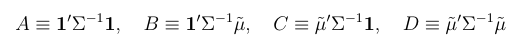

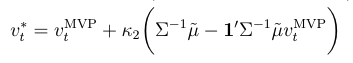

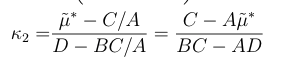

In [68]:
mu_tilde = mu
A = mdot([one.T, Sigma_inv, one])
B = mdot([one.T, Sigma_inv, mu_tilde])
C = mdot([mu_tilde.T, Sigma_inv, one])
D = mdot([mu_tilde.T, Sigma_inv, mu_tilde])

mu_tilde_star = 50      # Desired annual return

def efficient_port(mu_tilde_star):
    k2 = (mu_tilde_star-divide(C, A))/(D-divide(dot(B, C), A))
    v_t_eff = v_t_mvp + k2*(dot(Sigma_inv, mu_tilde)-dot(B, v_t_mvp))
    return v_t_eff

v_t_eff = efficient_port(mu_tilde_star)

### Applying the two mutual fund theorem

In [69]:
def port_std(weights):
    return mdot([weights.T, Sigma, weights])*(250**0.5)
    #return (returns.values*weights).std()*(250**0.5)

In [70]:
#frontier_weights = [c*efficient_port(mu_tilde_star)+(1-c)*efficient_port(dot(mu_tilde.T, v_t_mvp)) for c in np.arange(0, 1.5, 0.01)]
frontier_weights = [efficient_port(c) for c in np.arange(-40, 200, 1)]
frontier_mu = [dot(mu_tilde.T, w) for w in frontier_weights]
frontier_std = [port_std(w) for w in frontier_weights]

In [71]:
plt.style.use('seaborn')

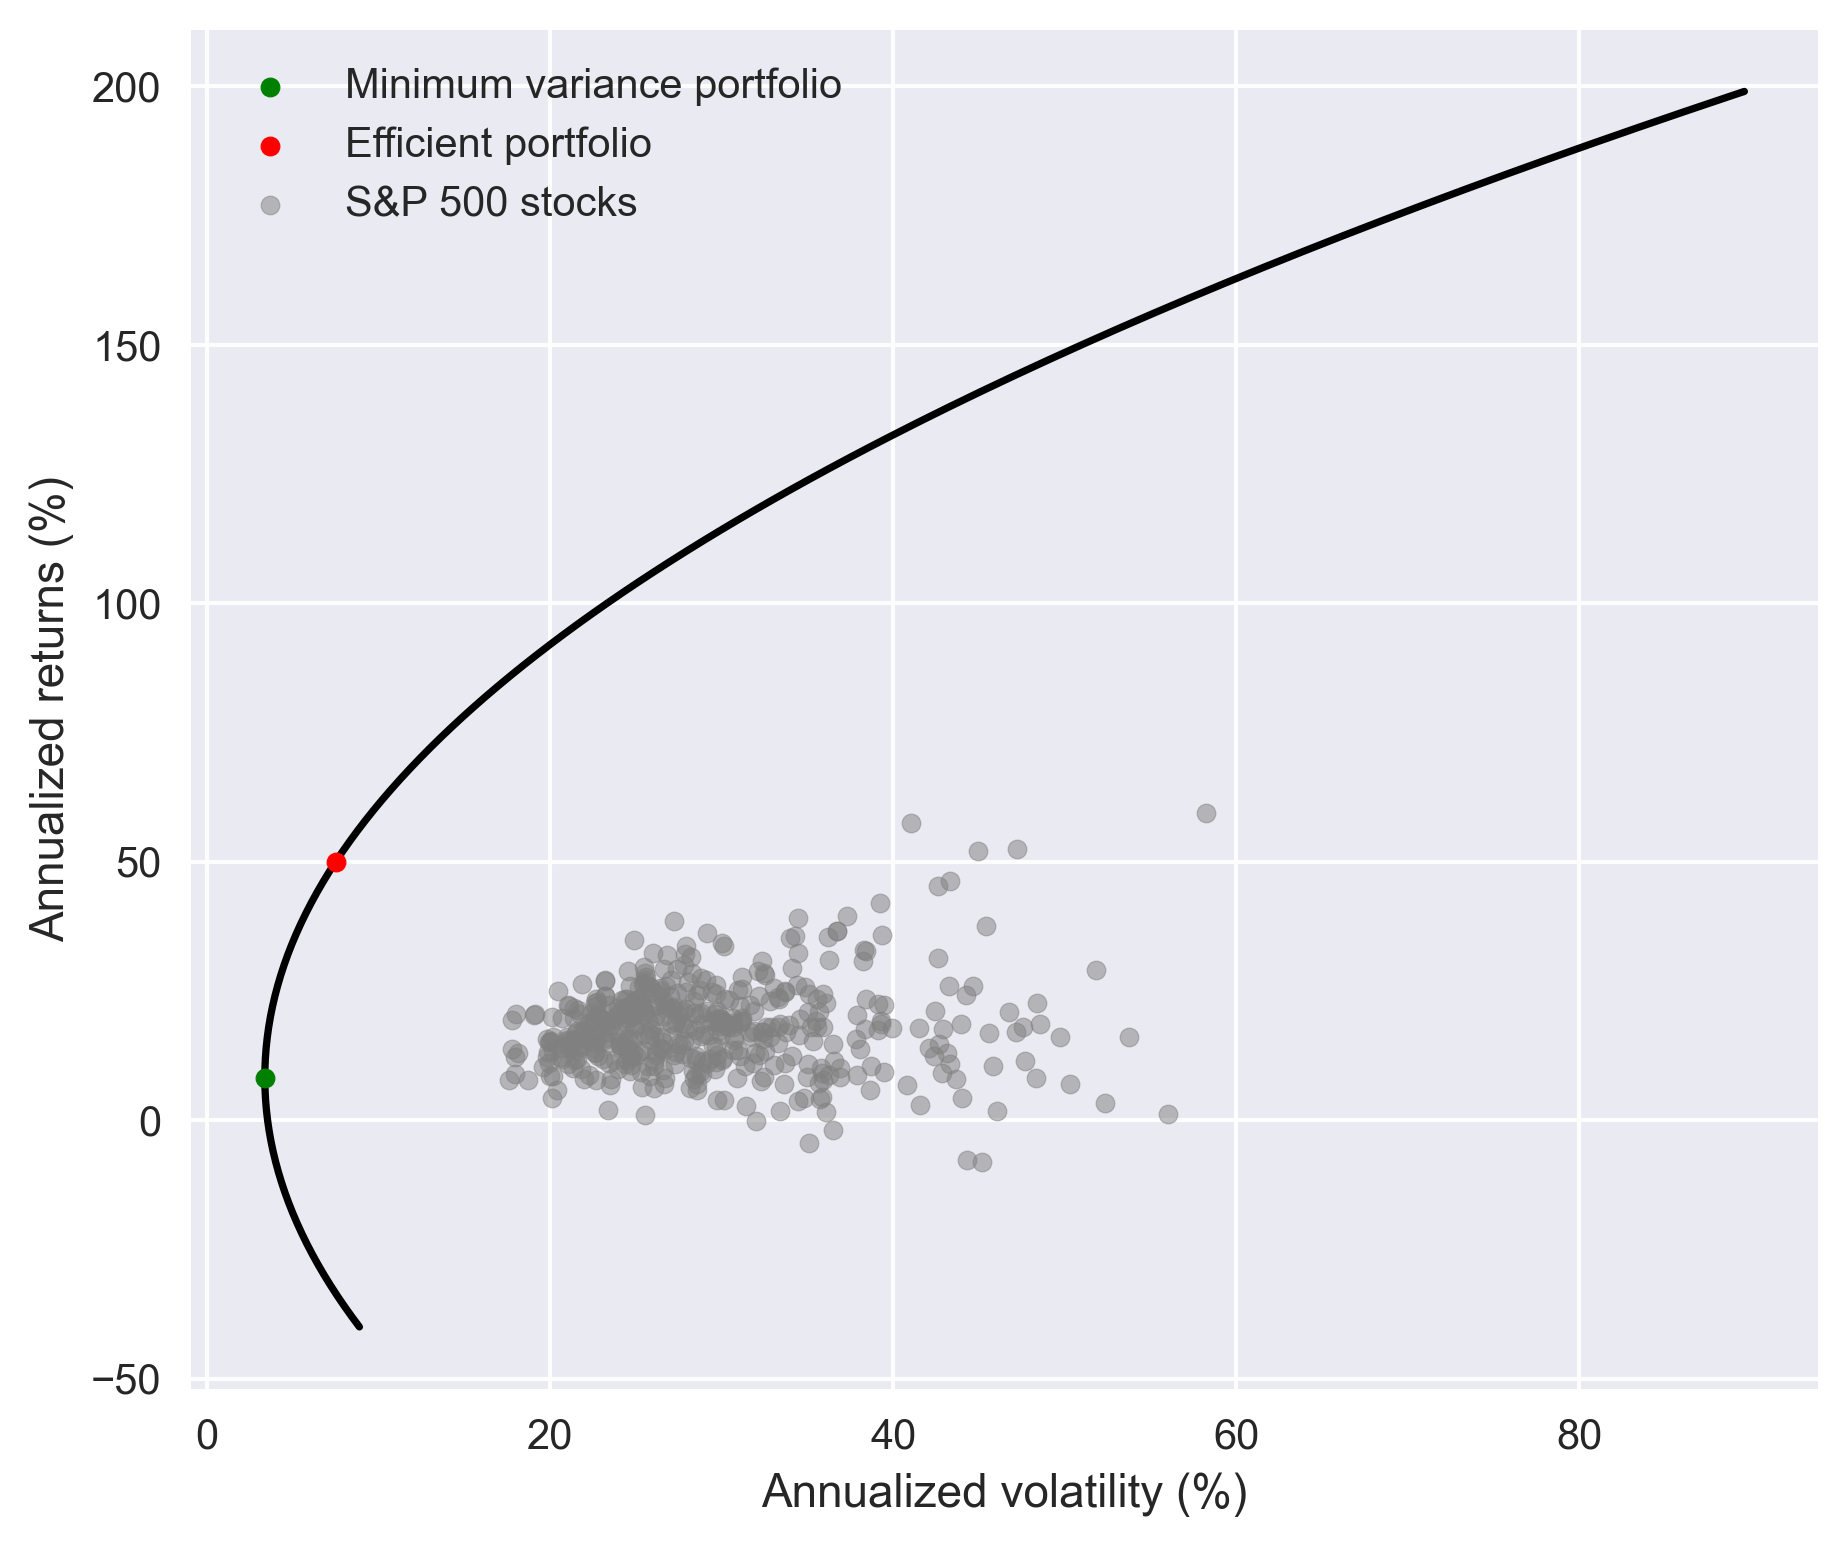

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6), dpi=300)
ax.scatter(port_std(v_t_mvp), dot(mu_tilde.T, v_t_mvp), color= "green", s=80, zorder=2, label="Minimum variance portfolio")
ax.scatter(port_std(v_t_eff), dot(mu_tilde.T, v_t_eff), color="red", s=80, zorder=2, label="Efficient portfolio")
ax.scatter(std, mu, color="grey", label="S&P 500 stocks", s=80, alpha=.5)
ax.plot(frontier_std, frontier_mu, zorder=1, color="black")
ax.set_xlabel("Annualized volatility (%)")
ax.set_ylabel("Annualized returns (%)")
ax.legend()
fig.savefig('efficient_frontier/theory_std_mu.png', bbox_inches="tight")

In [57]:
eff_perf = (returns.multiply(v_t_eff, axis=1).sum(axis=1)/100+1).cumprod()
eff_ = (returns.multiply(v_t_mvp, axis=1).sum(axis=1)/100+1).cumprod()

In [58]:
spx_data = yfinance.download(['SPY'], start = "2013-1-1")['Close']
spx_data = spx_data/spx_data.iloc[0]

[*********************100%***********************]  1 of 1 completed


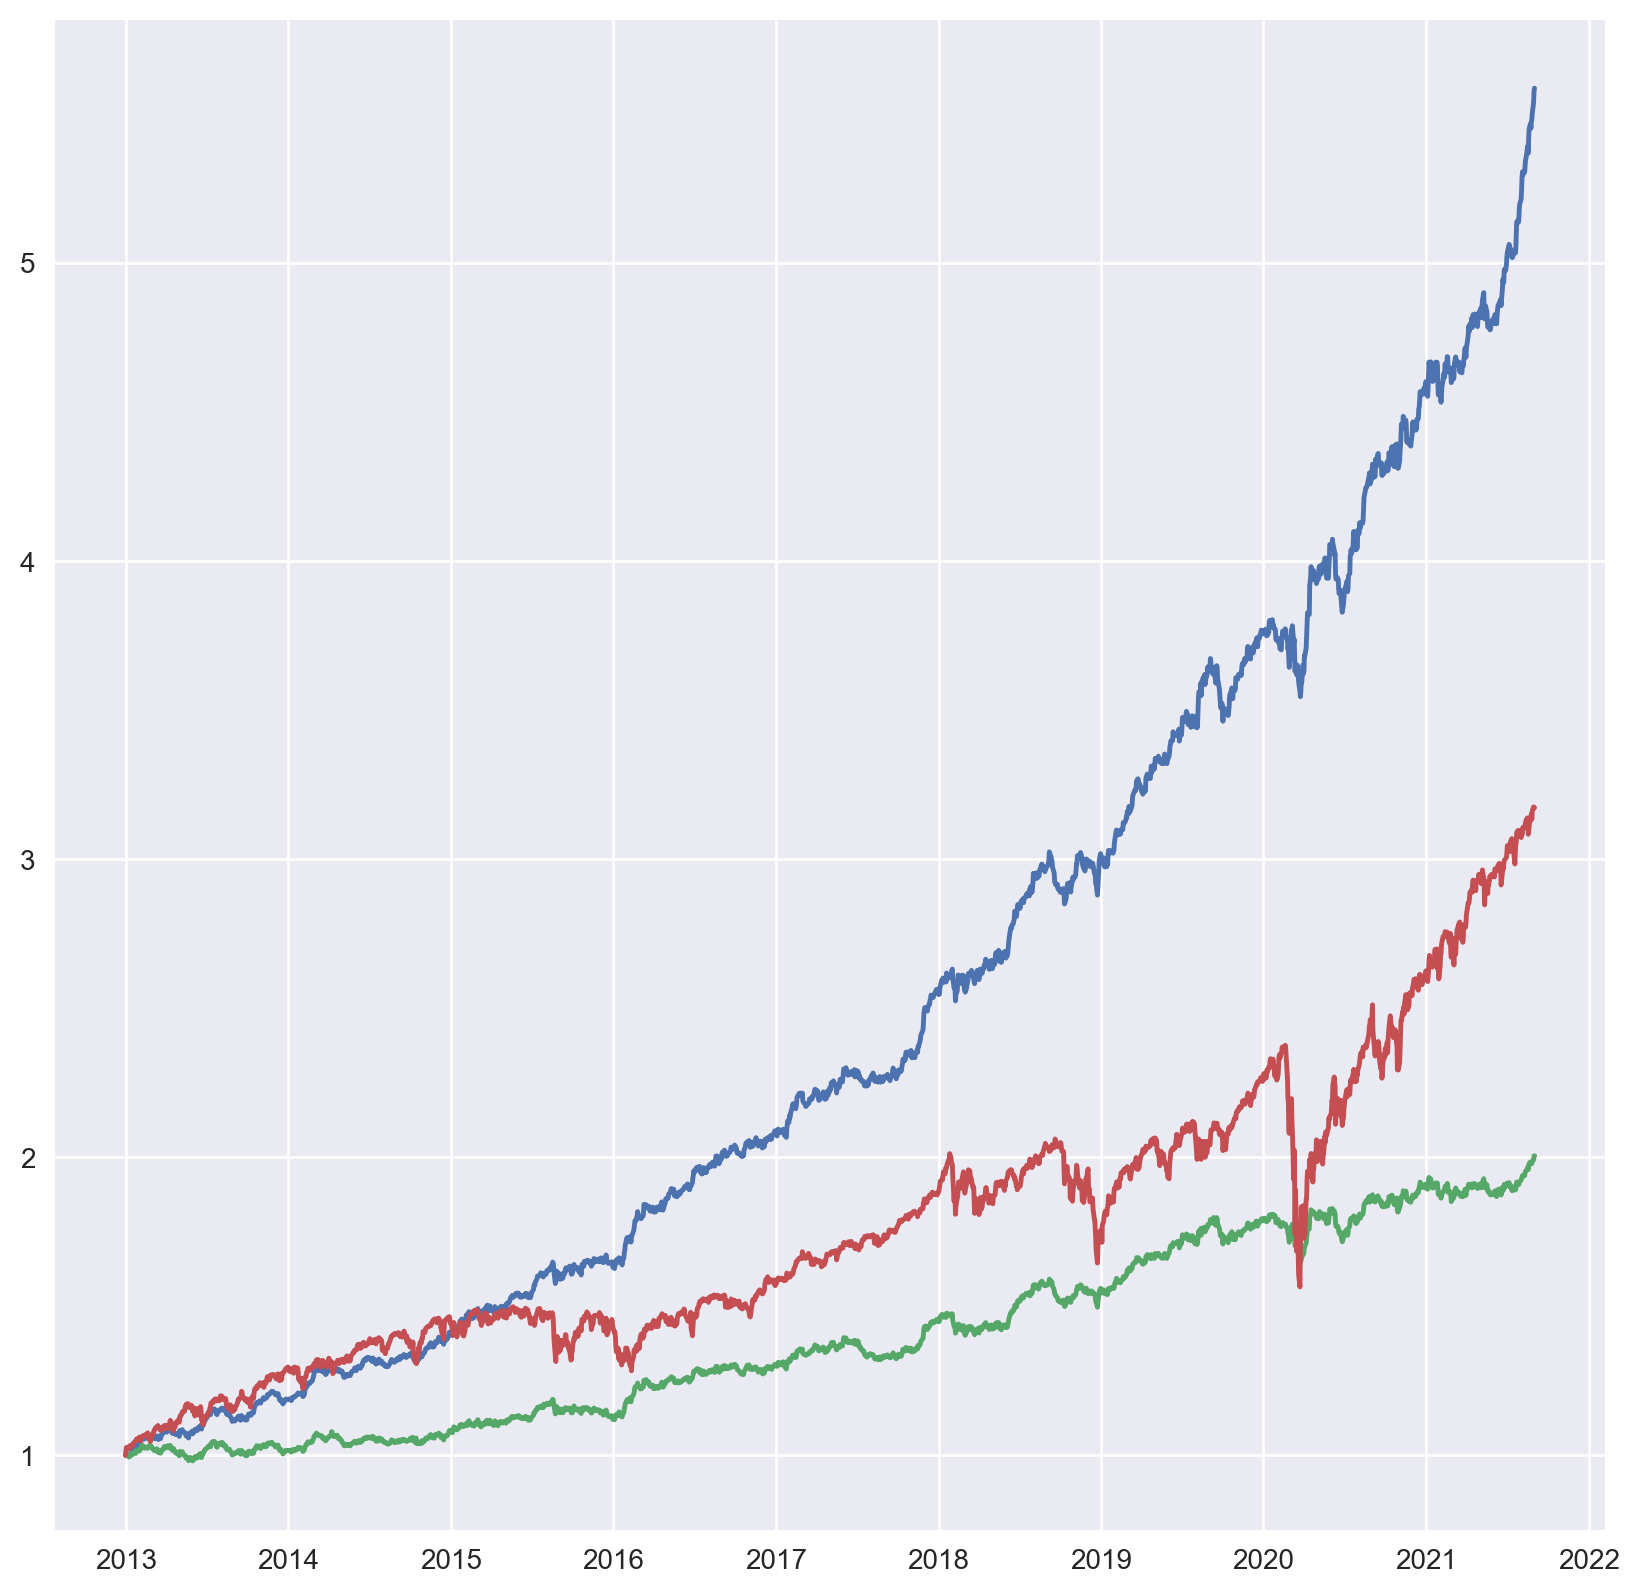

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(eff_perf)
ax.plot(eff_mvp)
ax.plot(spx_data)